# Trajectory Pose Inspection

This notebook focuses on:
- Visualizing **end-effector (EE)** and **object** poses in the **world frame**
- Plotting **EE gripper action** over time
- **Validating the relative object-to-EE pose** using ArUco pose chains

By default it will load the most recent `.npz` file from the `data/` directory, but you can change the path manually if needed.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.spatial.transform import Rotation as R

# Configure plots
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['axes.grid'] = True

DATA_DIR = Path('data')

# List available trajectories
npz_files = sorted(DATA_DIR.glob('trajectory_*.npz'))
print("Found trajectory files:")
for f in npz_files:
    print("  -", f)

# Choose latest by default
if npz_files:
    default_traj = npz_files[-1]
    print("\nUsing latest trajectory by default:", default_traj)
else:
    default_traj = None
    print("No trajectory_*.npz files found in data/")


Found trajectory files:
  - data/trajectory_20251215_134531.npz
  - data/trajectory_20251215_134614_1.npz
  - data/trajectory_20251215_134654_2.npz
  - data/trajectory_20251215_134809_3.npz
  - data/trajectory_20251215_134849_4.npz

Using latest trajectory by default: data/trajectory_20251215_134849_4.npz


In [2]:
# === Load Trajectory ===
# You can override this path manually if you want a specific file.
trajectory_file = default_traj  # e.g., Path('data/trajectory_20251215_134849_4.npz')

if trajectory_file is None:
    raise FileNotFoundError("No trajectory file found in data/. Add a trajectory_*.npz or set trajectory_file manually.")

print("Loading:", trajectory_file)

data = np.load(trajectory_file, allow_pickle=True)

# Core data
timestamps = data['timestamps']
states = data['states']
actions = data['actions']
metadata = data['metadata'].item() if 'metadata' in data else {}

# EE pose from Mujoco (for reference)
ee_poses_debug = data['ee_poses_debug'] if 'ee_poses_debug' in data else None

# ArUco data (poses are [x, y, z, qw, qx, qy, qz])
aruco_keys = [
    'aruco_ee_in_world',
    'aruco_object_in_world',
    'aruco_ee_in_object',
    'aruco_object_in_ee',
    'aruco_visibility',
]
aruco_data = {k: data[k] for k in aruco_keys if k in data}

print("\nTrajectory loaded!")
print(f"  File: {trajectory_file}")
print(f"  Num samples: {len(timestamps)}")
print(f"  Duration: {timestamps[-1]:.2f} s")
print(f"  State shape: {states.shape}")
print(f"  Action shape: {actions.shape}")
if ee_poses_debug is not None:
    print(f"  EE pose (Mujoco) shape: {ee_poses_debug.shape}")

print("\nArUco keys present:")
for k in aruco_data.keys():
    print(f"  - {k}: {aruco_data[k].shape}")


Loading: data/trajectory_20251215_134849_4.npz

Trajectory loaded!
  File: data/trajectory_20251215_134849_4.npz
  Num samples: 513
  Duration: 25.63 s
  State shape: (513, 6)
  Action shape: (513, 7)
  EE pose (Mujoco) shape: (513, 7)

ArUco keys present:
  - aruco_ee_in_world: (513, 7)
  - aruco_object_in_world: (513, 7)
  - aruco_ee_in_object: (513, 7)
  - aruco_object_in_ee: (513, 7)
  - aruco_visibility: (513, 3)


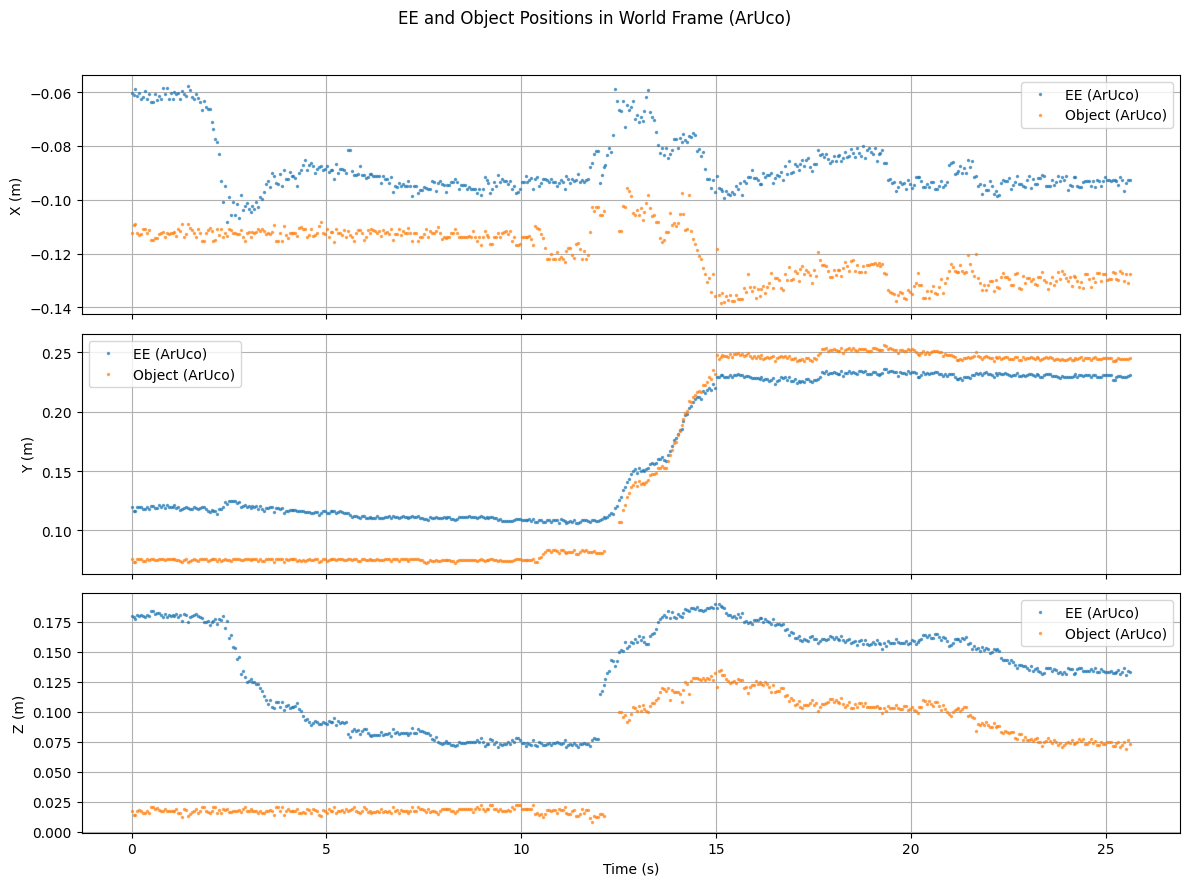

In [3]:
# === EE and Object Pose in World Frame ===
# Uses ArUco-derived world-frame poses.

if 'aruco_ee_in_world' not in aruco_data or 'aruco_object_in_world' not in aruco_data:
    print("World-frame ArUco data missing (need 'aruco_ee_in_world' and 'aruco_object_in_world').")
else:
    ee_in_world = aruco_data['aruco_ee_in_world']      # [N, 7]
    obj_in_world = aruco_data['aruco_object_in_world'] # [N, 7]
    vis = aruco_data.get('aruco_visibility', np.ones((len(timestamps), 3)))

    # Visibility masks: world+gripper, world+object
    valid_ee = (vis[:, 0] > 0.5) & (vis[:, 2] > 0.5)
    valid_obj = (vis[:, 0] > 0.5) & (vis[:, 1] > 0.5)

    labels = ['X', 'Y', 'Z']
    fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

    for i in range(3):
        axes[i].plot(timestamps[valid_ee], ee_in_world[valid_ee, i], '.', label='EE (ArUco)', alpha=0.6, markersize=3)
        axes[i].plot(timestamps[valid_obj], obj_in_world[valid_obj, i], '.', label='Object (ArUco)', alpha=0.6, markersize=3)
        axes[i].set_ylabel(f'{labels[i]} (m)')
        axes[i].legend()

    axes[-1].set_xlabel('Time (s)')
    fig.suptitle('EE and Object Positions in World Frame (ArUco)')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


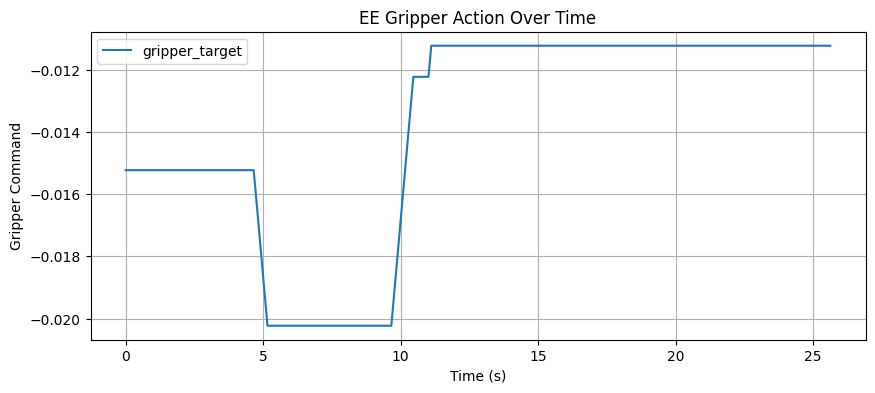

Gripper action index: 6 (gripper_target)


In [4]:
# === EE Gripper Action Over Time ===

action_labels = metadata.get('action_labels', ['vx', 'vy', 'vz', 'wx', 'wy', 'wz', 'gripper'])
num_actions = actions.shape[1]

# Identify gripper action index
if 'gripper' in action_labels:
    gripper_idx = action_labels.index('gripper')
elif 'gripper_target' in action_labels:
    gripper_idx = action_labels.index('gripper_target')
else:
    gripper_idx = num_actions - 1  # fallback: last dim

plt.figure(figsize=(10, 4))
plt.plot(timestamps, actions[:, gripper_idx], label=action_labels[gripper_idx])
plt.xlabel('Time (s)')
plt.ylabel('Gripper Command')
plt.title('EE Gripper Action Over Time')
plt.grid(True)
plt.legend()
plt.show()

print(f"Gripper action index: {gripper_idx} ({action_labels[gripper_idx]})")


In [6]:
# === Interactive 3D Trajectory (Plotly) ===
# Visualize EE and Object motion in 3D world space.

import plotly.graph_objects as go
import plotly.io as pio

if 'aruco_ee_in_world' not in aruco_data or 'aruco_object_in_world' not in aruco_data:
    print("World-frame ArUco data missing (need 'aruco_ee_in_world' and 'aruco_object_in_world').")
else:
    ee_in_world = aruco_data['aruco_ee_in_world']      # [N, 7]
    obj_in_world = aruco_data['aruco_object_in_world'] # [N, 7]
    vis = aruco_data.get('aruco_visibility', np.ones((len(timestamps), 3)))

    valid_ee = (vis[:, 0] > 0.5) & (vis[:, 2] > 0.5)
    valid_obj = (vis[:, 0] > 0.5) & (vis[:, 1] > 0.5)

    fig = go.Figure()

    # EE path as a line
    fig.add_trace(go.Scatter3d(
        x=ee_in_world[valid_ee, 0],
        y=ee_in_world[valid_ee, 1],
        z=ee_in_world[valid_ee, 2],
        mode='lines',
        name='EE path',
        line=dict(color='blue', width=4),
        opacity=0.8,
    ))

    # Object positions as markers
    fig.add_trace(go.Scatter3d(
        x=obj_in_world[valid_obj, 0],
        y=obj_in_world[valid_obj, 1],
        z=obj_in_world[valid_obj, 2],
        mode='markers',
        name='Object',
        marker=dict(size=4, color='red', opacity=0.6),
    ))

    # Optional: world origin marker
    fig.add_trace(go.Scatter3d(
        x=[0], y=[0], z=[0],
        mode='markers',
        name='World origin',
        marker=dict(size=8, color='black', symbol='x'),
    ))

    fig.update_layout(
        title=f"3D EE and Object Trajectory in World Frame ({trajectory_file.name})",
        scene=dict(
            xaxis_title='X (m)',
            yaxis_title='Y (m)',
            zaxis_title='Z (m)',
            aspectmode='data',
        ),
        width=900,
        height=700,
        legend=dict(itemsizing='constant'),
        margin=dict(l=0, r=0, b=0, t=40),
    )

    fig.show()
